# Autoencoder-LSTM Performance Analysis

## Notebook Overview 
This notebook is dedicated to the evaluation of an LSTM Autoencoder model, trained according to the _evaluate_autoencoders_ notebook available in the project.

### Imports
This section imports essential libraries used throughout the notebook and adds the 'src' directory to the system path to allow importing modules from the source folder. 

In [1]:
import pandas as pd
import numpy as np
import sys
import os
from sklearn.metrics import mean_squared_error
# Getting src path to import modules
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))

# Adding src path to the system path, if not already added
if src_path not in sys.path:
    sys.path.append(src_path)

from dl_models import AutoencoderLSTM as ael
from dl_models import AutoencoderLSTMKfold as aelk
from utils import plots as plt

## Introductory tests
Following the baseline Autoencoder test on Building 1 (see first notebook), we now adopt an Autoencoder-LSTM to exploit the sequential nature of the data. The model encodes input sequences into a latent vector, which is then repeated and decoded to reconstruct the time series, enabling the capture of temporal dependencies

In [2]:
# Time series data for a specific building (Building_1.csv/Building_2.csv/Building_3.csv).
electricity_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/Building_1.csv")

# Carbon intensity data.
carbon_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/carbon_intensity.csv")

# Pricing data.
pricing_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/pricing.csv")

# Weather data.
weather_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/weather.csv")

# Concatenate multiple datasets along the columns to create a single dataset.
df = pd.concat([electricity_data, carbon_data, pricing_data, weather_data], axis=1)

# Displaying the last 5 samples of the dataframe to show its structure.
df.tail()

,month,hour,day_type,daylight_savings_status,indoor_dry_bulb_temperature,average_unmet_cooling_setpoint_difference,indoor_relative_humidity,non_shiftable_load,dhw_demand,cooling_demand,...,outdoor_dry_bulb_temperature_predicted_24h,outdoor_relative_humidity_predicted_6h,outdoor_relative_humidity_predicted_12h,outdoor_relative_humidity_predicted_24h,diffuse_solar_irradiance_predicted_6h,diffuse_solar_irradiance_predicted_12h,diffuse_solar_irradiance_predicted_24h,direct_solar_irradiance_predicted_6h,direct_solar_irradiance_predicted_12h,direct_solar_irradiance_predicted_24h
715,6,20,6,0,24.468618,0.024173,54.277103,0.442291,0.398354,5.189857,...,32.905895,89.465866,73.861000,40.875510,0.0,110.15520,0.0,0.0,271.32200,0.0
716,6,21,6,0,24.444859,0.000415,54.351337,0.990416,0.199180,4.550693,...,32.669003,87.158066,66.389130,64.036320,0.0,216.20418,0.0,0.0,151.80556,0.0
717,6,22,6,0,24.444464,0.000019,54.532566,1.563732,0.000000,4.043389,...,29.979940,100.000000,58.228535,51.990180,0.0,259.28485,0.0,0.0,374.21823,0.0
718,6,23,6,0,24.444452,0.000009,54.647182,0.421510,0.000000,3.268111,...,28.337627,90.768420,35.361465,60.445404,0.0,272.40073,0.0,0.0,582.50290,0.0
719,6,24,6,0,21.812447,0.145780,63.234272,0.374985,0.000000,6.492827,...,25.415920,82.899440,47.129494,56.078560,0.0,129.96535,0.0,0.0,842.14680,0.0


In [3]:
# Target features to forecast
targets = ['cooling_demand', 'carbon_intensity', 'solar_generation']

# List of features used for training the autoencoder.
features = ['month', 'hour', 'day_type', 'daylight_savings_status', 'indoor_dry_bulb_temperature', 'average_unmet_cooling_setpoint_difference', 
            'indoor_relative_humidity', 'non_shiftable_load', 'dhw_demand', 'cooling_demand', 'heating_demand', 'solar_generation', 'occupant_count', 
            'indoor_dry_bulb_temperature_set_point', 'hvac_mode', 'carbon_intensity', 'electricity_pricing', 
            'electricity_pricing_predicted_6h', 'electricity_pricing_predicted_12h', 'electricity_pricing_predicted_24h', 
            'outdoor_dry_bulb_temperature', 'outdoor_relative_humidity', 'diffuse_solar_irradiance', 'direct_solar_irradiance', 
            'outdoor_dry_bulb_temperature_predicted_6h', 'outdoor_dry_bulb_temperature_predicted_12h', 'outdoor_dry_bulb_temperature_predicted_24h', 
            'outdoor_relative_humidity_predicted_6h', 'outdoor_relative_humidity_predicted_12h', 'outdoor_relative_humidity_predicted_24h', 
            'diffuse_solar_irradiance_predicted_6h', 'diffuse_solar_irradiance_predicted_12h', 'diffuse_solar_irradiance_predicted_24h', 
            'direct_solar_irradiance_predicted_6h', 'direct_solar_irradiance_predicted_12h', 'direct_solar_irradiance_predicted_24h']

In [5]:
real_1, pred_1, _ = ael.Autoencoder(dataframe=df, features=features, epochs = 150, batch_size=64, latent_dim=256, timesteps = 6)

Epoch 1/150
8/8 [==============================] - 2s 40ms/step - loss: 0.1555
Epoch 2/150
8/8 [==============================] - 0s 34ms/step - loss: 0.0857
Epoch 3/150
8/8 [==============================] - 0s 31ms/step - loss: 0.0747
Epoch 4/150
8/8 [==============================] - 0s 33ms/step - loss: 0.0666
Epoch 5/150
8/8 [==============================] - 0s 37ms/step - loss: 0.0610
Epoch 6/150
8/8 [==============================] - 0s 30ms/step - loss: 0.0565
Epoch 7/150
8/8 [==============================] - 0s 37ms/step - loss: 0.0545
Epoch 8/150
8/8 [==============================] - 0s 28ms/step - loss: 0.0535
Epoch 9/150
8/8 [==============================] - 0s 33ms/step - loss: 0.0529
Epoch 10/150
8/8 [==============================] - 0s 36ms/step - loss: 0.0525
Epoch 11/150
8/8 [==============================] - 0s 37ms/step - loss: 0.0519
Epoch 12/150
8/8 [==============================] - 0s 34ms/step - loss: 0.0515
Epoch 13/150
8/8 [==============================]

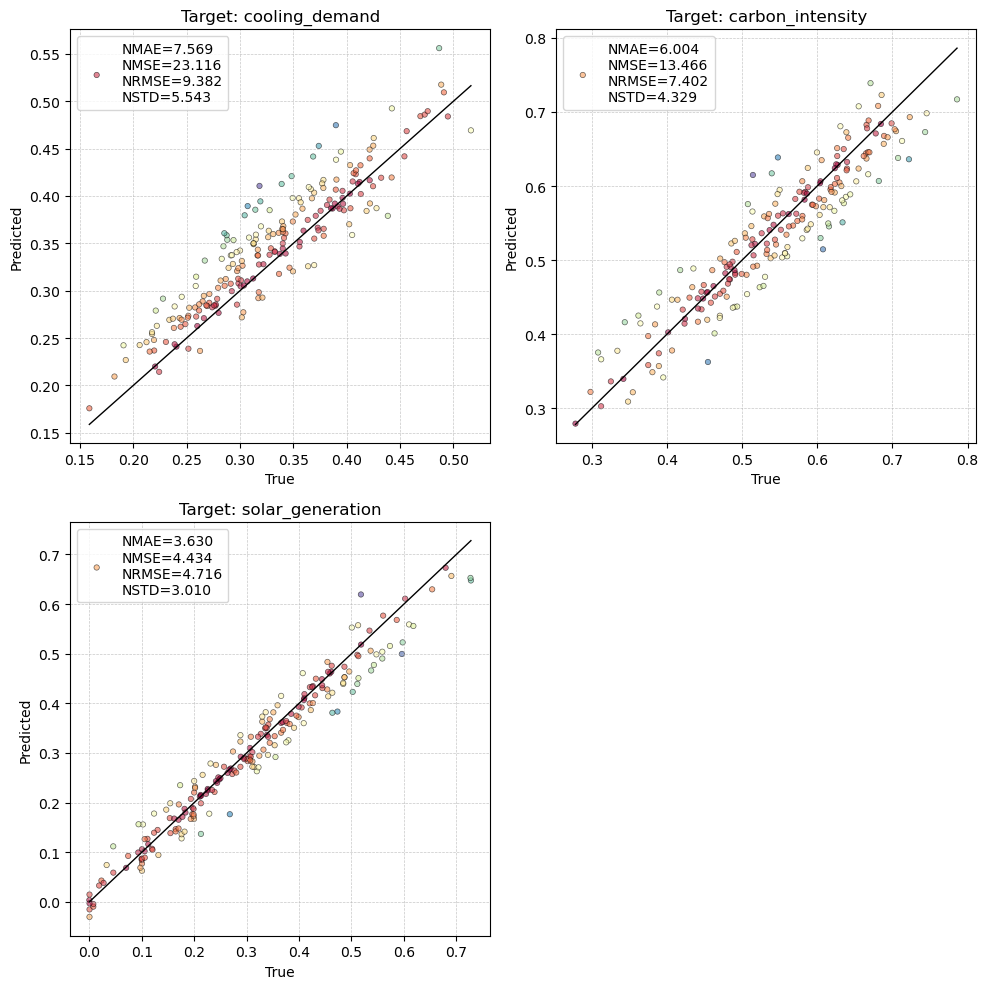

In [6]:
plt.plot_aelstm_targets(real_1, pred_1, targets, features, percent=True)

## Cross-Building Test
The targets and the model remain unchanged. For this phase, we will use 100% of the data from Building 1 for training, while the remaining two buildings, being triplets with the first, will be used to evaluate the model's performance.

In [7]:
## Time series data for all buildings
building_1_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/Building_1.csv")
building_2_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/Building_2.csv")
building_3_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/Building_3.csv")

# Concatenate train and test data
train_df = pd.concat([building_1_data, carbon_data, pricing_data, weather_data], axis=1)

# Concatenate the data from Building 2 and Building 3 vertically, creating a unified dataset for evaluation
building_2_3_data = pd.concat([building_2_data, building_3_data], axis=0, ignore_index=True)

# Combine carbon intensity, pricing, and weather data horizontally to align with building data
external_data = pd.concat([carbon_data, pricing_data, weather_data], axis=1)

# Repeat the external data (carbon, pricing, weather) to match the number of rows in Building 2 and 3 data
external_data_repeated = pd.concat([external_data] * 2, axis=0, ignore_index=True)

# Combine the building data and the repeated external data horizontally, preparing the final test dataset
test_df = pd.concat([building_2_3_data, external_data_repeated], axis=1)

In [8]:
real_2, pred_2, model = ael.Autoencoder(train_df=train_df, test_df=test_df, features=features, epochs = 150, batch_size = 64, latent_dim = 256, timesteps = 6)
model.save(os.path.join("..", "reports", "models", "autoencoderLSTM_generalization.h5"))

Epoch 1/150
12/12 [==============================] - 2s 40ms/step - loss: 0.1276
Epoch 2/150
12/12 [==============================] - 0s 39ms/step - loss: 0.0666
Epoch 3/150
12/12 [==============================] - 0s 38ms/step - loss: 0.0437
Epoch 4/150
12/12 [==============================] - 0s 37ms/step - loss: 0.0309
Epoch 5/150
12/12 [==============================] - 0s 34ms/step - loss: 0.0244
Epoch 6/150
12/12 [==============================] - 0s 33ms/step - loss: 0.0203
Epoch 7/150
12/12 [==============================] - 0s 34ms/step - loss: 0.0178
Epoch 8/150
12/12 [==============================] - 0s 39ms/step - loss: 0.0163
Epoch 9/150
12/12 [==============================] - 0s 35ms/step - loss: 0.0152
Epoch 10/150
12/12 [==============================] - 0s 37ms/step - loss: 0.0143
Epoch 11/150
12/12 [==============================] - 0s 35ms/step - loss: 0.0135
Epoch 12/150
12/12 [==============================] - 0s 38ms/step - loss: 0.0129
Epoch 13/150
12/12 [=====

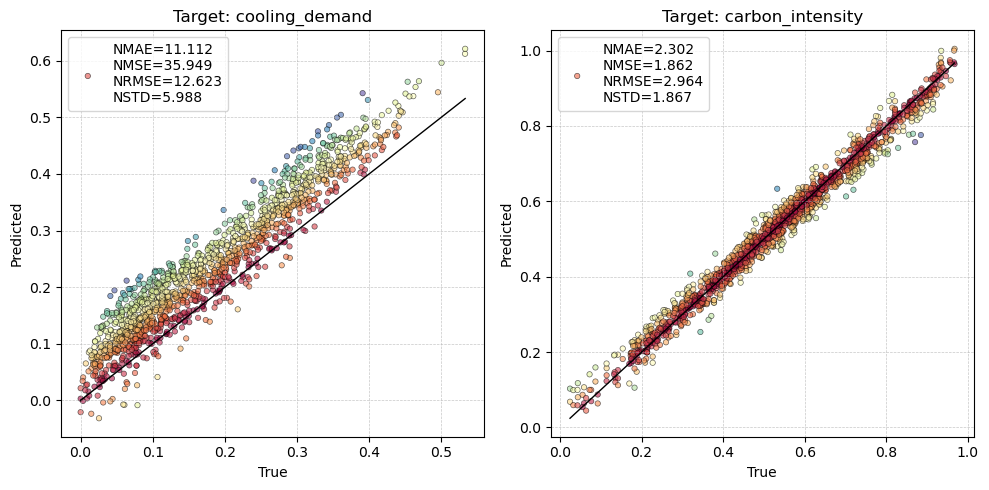

In [9]:
plt.plot_aelstm_targets(real_2, pred_2, targets[:2], features, percent=True)

## With K-fold Cross Validation
To ensure a more robust and unbiased evaluation of the LSTM autoencoder's performance, a K-Fold Cross-Validation approach is adopted.

### Tuning

In [10]:
electricity_d = pd.read_csv("../data/citylearn_challenge_2023_phase_1/Building_2.csv")
df2 = pd.concat([electricity_d, carbon_data, pricing_data, weather_data], axis=1)

In [11]:
real_3, pred_3, model = aelk.Autoencoder(dataframe = df2, features = features, epochs = 75, batch_size = 64, latent_dim = 256, timesteps = 6, kfold = 5)
model.save(os.path.join("..", "reports", "models", "autoencoderLSTM_kfoldtuning.h5"))


Fold 1/5
Epoch 1/75
9/9 [==============================] - 2s 52ms/step - loss: 0.1558
Epoch 2/75
9/9 [==============================] - 0s 35ms/step - loss: 0.0793
Epoch 3/75
9/9 [==============================] - 0s 37ms/step - loss: 0.0596
Epoch 4/75
9/9 [==============================] - 0s 40ms/step - loss: 0.0431
Epoch 5/75
9/9 [==============================] - 0s 33ms/step - loss: 0.0345
Epoch 6/75
9/9 [==============================] - 0s 35ms/step - loss: 0.0292
Epoch 7/75
9/9 [==============================] - 0s 31ms/step - loss: 0.0255
Epoch 8/75
9/9 [==============================] - 0s 40ms/step - loss: 0.0226
Epoch 9/75
9/9 [==============================] - 0s 37ms/step - loss: 0.0204
Epoch 10/75
9/9 [==============================] - 0s 41ms/step - loss: 0.0189
Epoch 11/75
9/9 [==============================] - 0s 38ms/step - loss: 0.0177
Epoch 12/75
9/9 [==============================] - 0s 32ms/step - loss: 0.0169
Epoch 13/75
9/9 [==============================] - 

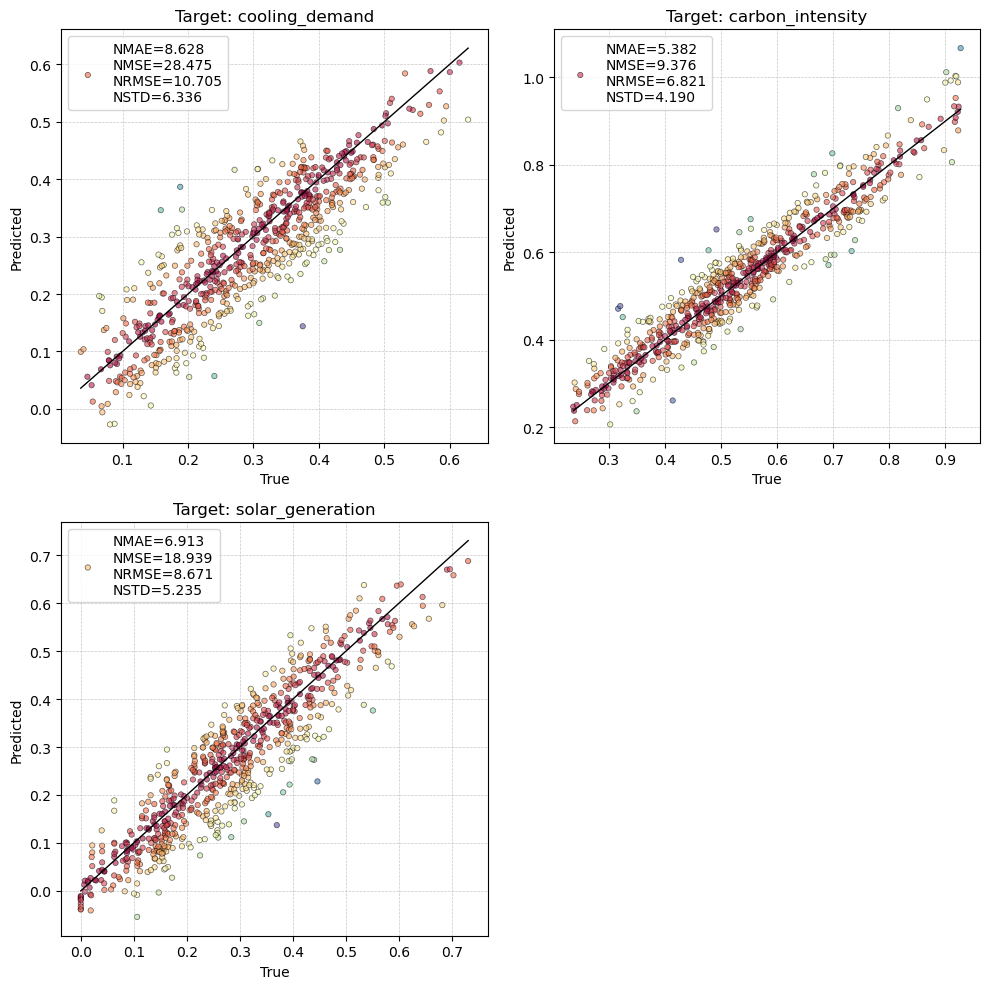

In [12]:
plt.plot_aelstm_targets(real_3, pred_3, targets, features, percent=True)

### Final Training

In [13]:
electricity_d = pd.read_csv("../data/citylearn_challenge_2023_phase_1/Building_3.csv")
df3 = pd.concat([electricity_d, carbon_data, pricing_data, weather_data], axis=1)

In [14]:
real_4, pred_4, model = aelk.Autoencoder(dataframe=df3, features=features, epochs = 150, latent_dim = 256, batch_size = 64, timesteps = 6)
model.save(os.path.join("..", "reports", "models", "autoencoderLSTM_kfoldtrain.h5"))

Epoch 1/150
8/8 [==============================] - 2s 38ms/step - loss: 0.1606
Epoch 2/150
8/8 [==============================] - 0s 34ms/step - loss: 0.0888
Epoch 3/150
8/8 [==============================] - 0s 34ms/step - loss: 0.0768
Epoch 4/150
8/8 [==============================] - 0s 36ms/step - loss: 0.0687
Epoch 5/150
8/8 [==============================] - 0s 37ms/step - loss: 0.0622
Epoch 6/150
8/8 [==============================] - 0s 39ms/step - loss: 0.0589
Epoch 7/150
8/8 [==============================] - 0s 36ms/step - loss: 0.0565
Epoch 8/150
8/8 [==============================] - 0s 33ms/step - loss: 0.0555
Epoch 9/150
8/8 [==============================] - 0s 36ms/step - loss: 0.0548
Epoch 10/150
8/8 [==============================] - 0s 37ms/step - loss: 0.0543
Epoch 11/150
8/8 [==============================] - 0s 33ms/step - loss: 0.0538
Epoch 12/150
8/8 [==============================] - 0s 29ms/step - loss: 0.0535
Epoch 13/150
8/8 [==============================]

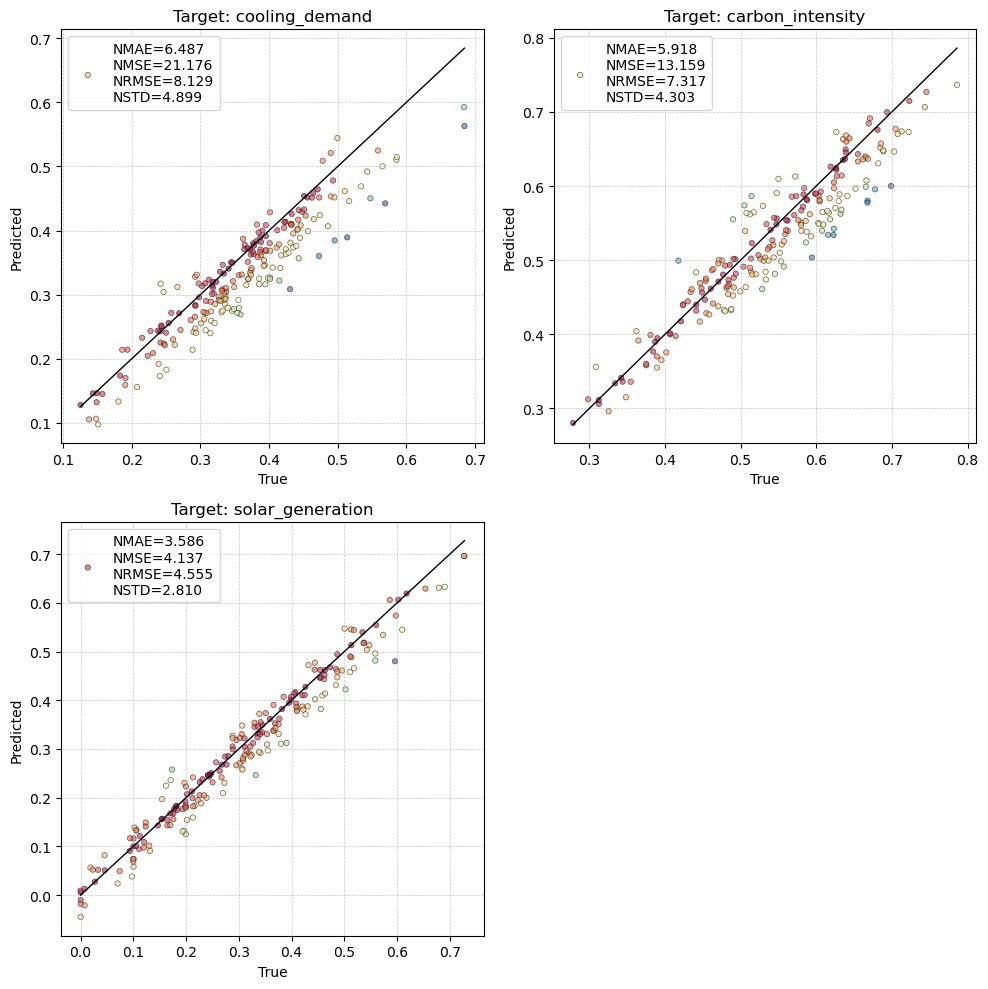

In [15]:
plt.plot_aelstm_targets(real_4, pred_4, targets, features, percent=True)